In [1]:
import importlib
import DSP
importlib.reload(DSP)
import Regression
importlib.reload(Regression)

<module 'Regression' from '/Users/rohankotwani/Documents/Complex-Time-Series-Signal-Processing/Regression.py'>

In [2]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd

In [3]:
full=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Sessions':int,'Pageviews':int})

full['time']=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Day ']].values]
full=full.sort_values(by=['time'])
full['index']=DSP.datetime_index(full['time'])+1
assert len(full['index']) == np.max(full['index'])

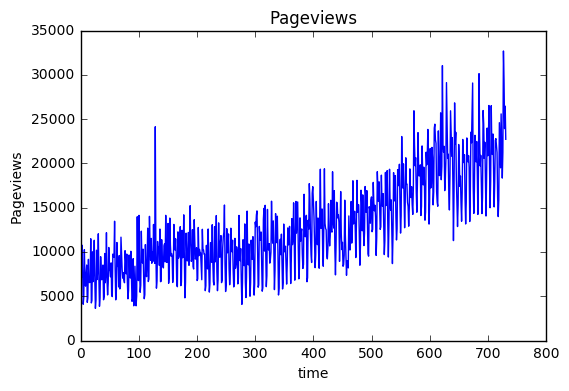

In [4]:
train=full[:580].copy()
valid=full[580:].copy()
train.head(n=5)

plt.plot(full['index'],full['Pageviews'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.title('Pageviews')
plt.show()

### Differenced time series

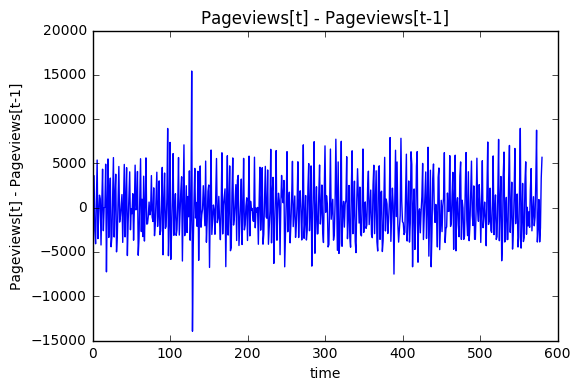

In [5]:
time_diff_signal = DSP.time_diff_variable(train['Pageviews'],1)
plt.plot(train['index'][1:],time_diff_signal,'-');plt.xlabel('time');plt.ylabel('Pageviews[t] - Pageviews[t-1]');plt.title('Pageviews[t] - Pageviews[t-1]')
plt.show()

### FFT transformation

/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


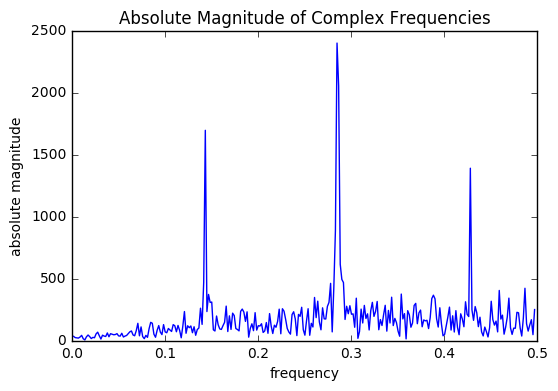

In [6]:
N = len(time_diff_signal)
unfiltered  = DSP.get_frequency_domain(time_diff_signal)
f,y  = unfiltered[:,0],unfiltered[:,1]
y_abs=( 2.0/N * np.abs(y[1:]))
plt.plot(f[1:],y_abs);plt.xlabel('frequency');plt.ylabel('absolute magnitude');plt.title("Absolute Magnitude of Complex Frequencies")
plt.show()

### Filtering frequency domain: center, band, and threshold

In [7]:
abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=0.3,band=0.2,threshold=500))
print("Frequency, Magnitude")
print(abs_filtered)

period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])
print("periods: ",period_list)

Frequency, Magnitude
[[  1.43350604e-01   4.90708355e+05]
 [  2.83246978e-01   2.56599629e+05]
 [  2.84974093e-01   6.94399643e+05]
 [  2.86701209e-01   5.94537387e+05]
 [  2.88428325e-01   1.77929454e+05]
 [  4.28324698e-01   4.02209876e+05]]
periods:  {3.0, 4.0, 7.0}


### Overall trend: Polynomial regression

R-squared:  -0.031623111497


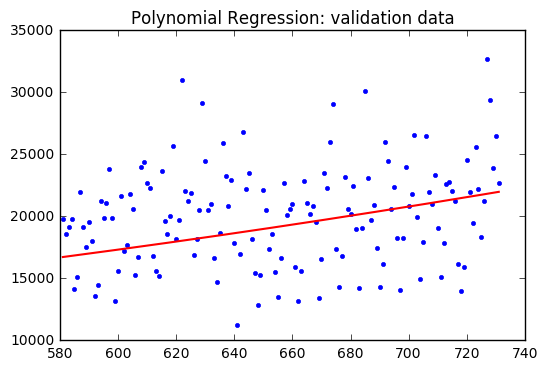

In [8]:
heap = []
for i in range(1,15):
    z=Regression.sklearn_poly_regression(train[['index']],train[['Pageviews']],i)
    SSE = Regression.numpy_poly_regression_SSE(valid[['index']],valid[['Pageviews']],i,z)
    heap.append((SSE,i))

power = int(Regression.heapsort(heap)[0][1])

T_train = Regression.pandas_poly_feature(train[['index']],power).values
T_valid = Regression.pandas_poly_feature(valid[['index']],power).values

z = Regression.numpy_simple_regression(T_train,train[['Pageviews']].values)
predict = Regression.numpy_predict(T_valid,z)
SSE = Regression.numpy_SSE(T_valid,valid[['Pageviews']],z)
SST = np.sum((valid['Pageviews']-np.mean(valid['Pageviews']))**2)

print("R-squared: ",1-SSE/SST)
plt.plot(valid['index'],valid['Pageviews'],'b.');plt.plot(valid['index'],predict,'r-',linewidth=1.5);plt.title("Polynomial Regression: validation data")
plt.show()

### Seasonal Components : Waveform generation

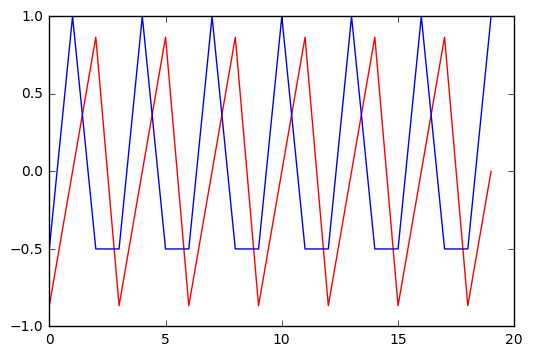

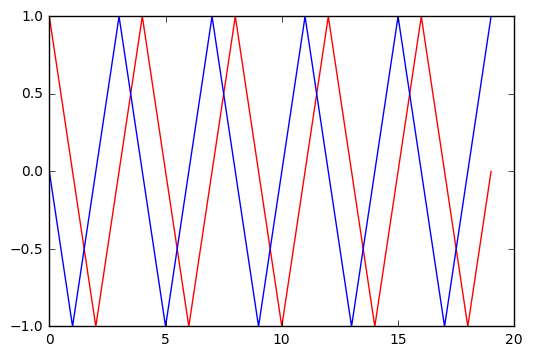

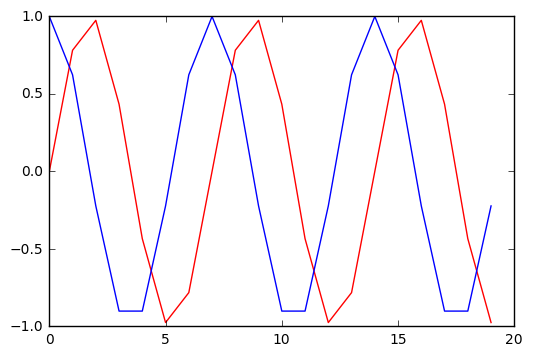

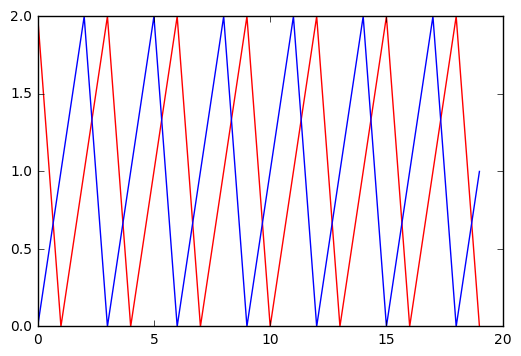

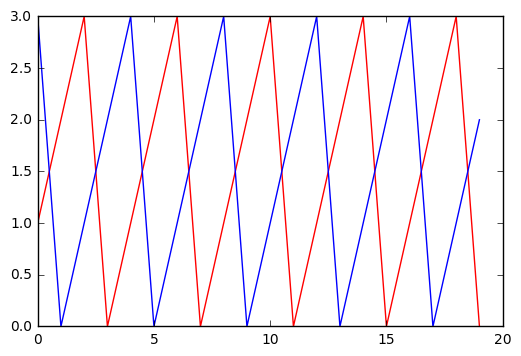

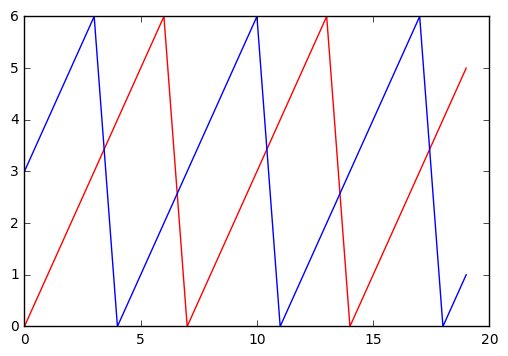

In [9]:

S_train = np.ones((len(train),1))
S_valid = np.ones((len(valid),1))
for period in period_list:
    
    x = DSP.generate_sin_waves(train['index'],period)
    S_train=np.column_stack((S_train,x))
    x = DSP.generate_sin_waves(valid['index'],period)
    S_valid=np.column_stack((S_valid,x))
    
    sinx = x[:,0]
    cosx = x[:,1]
    plt.plot(sinx[:20],'r')
    plt.plot(cosx[:20],'b')
    plt.show()
    
for period in period_list:
    x = DSP.generate_sawtooth_waves(train['index'],period)
    S_train=np.column_stack((S_train,x))

    x = DSP.generate_sawtooth_waves(valid['index'],period)
    S_valid=np.column_stack((S_valid,x))
    
    sinx = x[:,0]
    cosx = x[:,1]
    plt.plot(sinx[:20],'r')
    plt.plot(cosx[:20],'b')
    plt.show()

S_train,S_valid = S_train[:,1:],S_valid[:,1:]

### Trend & Seasonal Components: x(t) = T(t) + S(t) +R(t) + error

In [10]:
heap = []
for i in range(1,15):
    T_train = Regression.pandas_poly_feature(train[['index']],i).values
    T_valid = Regression.pandas_poly_feature(valid[['index']],i).values

    
    for c in np.linspace(0.2,0.3,2):
        for b in np.linspace(0.2,0.3,2):
            for thresh in np.linspace(400,500,3):
                abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=c,band=b,threshold=thresh))

                period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])
#                 print(period_list)

                S_train = np.ones((len(train),1))
                S_valid = np.ones((len(valid),1))
                for period in period_list:

                    x = DSP.generate_sawtooth_waves(train['index'],period)
                    S_train=np.column_stack((S_train,x))
                    x = DSP.generate_sin_waves(train['index'],period)
                    S_train=np.column_stack((S_train,x))
                    x = DSP.generate_sawtooth_waves(valid['index'],period)
                    S_valid=np.column_stack((S_valid,x))
                    x = DSP.generate_sin_waves(valid['index'],period)
                    S_valid=np.column_stack((S_valid,x))

                S_train,S_valid = S_train[:,1:],S_valid[:,1:]
                
                P_train = np.column_stack((S_train,T_train))
                P_valid = np.column_stack((S_valid,T_valid))
                z = Regression.numpy_simple_regression(P_train,train[['Pageviews']])
                SSE = Regression.numpy_SSE(P_valid,valid[['Pageviews']],z)
                heap.append((SSE,i,c,b,thresh))


Regression.heapsort(heap)

[(1322030556.7158628, 2, 0.20000000000000001, 0.20000000000000001, 400.0),
 (1322030556.7158628, 2, 0.20000000000000001, 0.20000000000000001, 450.0),
 (1322030556.7158628, 2, 0.20000000000000001, 0.20000000000000001, 500.0),
 (1322030556.7158628, 2, 0.20000000000000001, 0.29999999999999999, 400.0),
 (1322030556.7158628, 2, 0.20000000000000001, 0.29999999999999999, 450.0),
 (1322030556.7158628, 2, 0.20000000000000001, 0.29999999999999999, 500.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.20000000000000001, 400.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.20000000000000001, 450.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.20000000000000001, 500.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.29999999999999999, 400.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.29999999999999999, 450.0),
 (1322030556.7158628, 2, 0.29999999999999999, 0.29999999999999999, 500.0),
 (3289360873.2290754, 1, 0.20000000000000001, 0.20000000000000001, 400.0),
 (3289360873.2290754, 1, 

In [11]:
SSE,i,c,b,thresh = Regression.heapsort(heap)[0]
print("model paramters: ",i,c,b,thresh)

model paramters:  2 0.2 0.2 400.0


R-squared:  0.454828560075


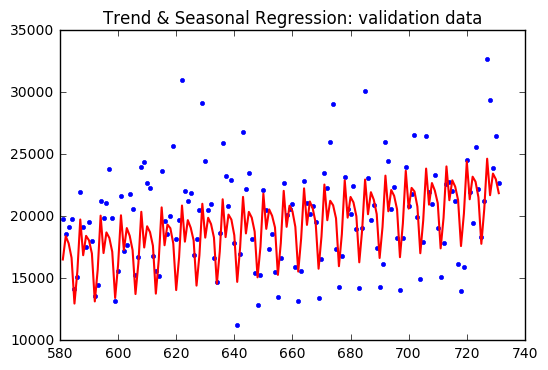

In [12]:
T_train = Regression.pandas_poly_feature(train[['index']],i).values
T_valid = Regression.pandas_poly_feature(valid[['index']],i).values
abs_filtered = np.absolute(DSP.filter_freq_domain(unfiltered, center=c,band=b,threshold=thresh))

period_list = set([round(1/(ft)) for ft,ht in abs_filtered if round(1/(ft))>2])

S_train = np.ones((len(train),1))
S_valid = np.ones((len(valid),1))
for period in period_list:

        x = DSP.generate_sawtooth_waves(train['index'],period)
        S_train=np.column_stack((S_train,x))
        x = DSP.generate_sin_waves(train['index'],period)
        S_train=np.column_stack((S_train,x))
        x = DSP.generate_sawtooth_waves(valid['index'],period)
        S_valid=np.column_stack((S_valid,x))
        x = DSP.generate_sin_waves(valid['index'],period)
        S_valid=np.column_stack((S_valid,x))

S_train,S_valid = S_train[:,1:],S_valid[:,1:]
                
P_train = np.column_stack((S_train,T_train))
P_valid = np.column_stack((S_valid,T_valid))
z = Regression.numpy_simple_regression(P_train,train[['Pageviews']])

predict = Regression.numpy_predict(P_valid,z)
SSE = Regression.numpy_SSE(P_valid,valid[['Pageviews']],z)
SST = np.sum((valid['Pageviews']-np.mean(valid['Pageviews']))**2)

print("R-squared: ",1-SSE/SST)
plt.plot(valid['index'],valid['Pageviews'],'b.');plt.plot(valid['index'],predict,'r-',linewidth=1.5);plt.title("Trend & Seasonal Regression: validation data")
plt.show()


